# TIME SERIES ANALYSIS OF ELECTRICITY DATA

## Import libraries

In [1]:
#!python -m pip install prophet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
def calculate_mape(actual_values, predicted_values):
    """
    Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values.
    """
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)
    absolute_percentage_errors = np.abs((actual_values - predicted_values) / actual_values)
    mape = (1 / len(actual_values)) * np.sum(absolute_percentage_errors) * 100
    return round(mape, 2)

## Load and Inspect the Data

In [4]:
# Load data to dataframe
data = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')

In [5]:
# Inspect dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [6]:
# First five rows
data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [7]:
# Convert FullDate to datetime object
data['FullDate'] = pd.to_datetime(data['FullDate'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [9]:
# Make FullDate the index
data.set_index('FullDate', inplace=True)

In [10]:
data.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [11]:
# Shape of dataset
data.shape

(92016, 4)

## Task 1

Using the daily sampling rate (sum), divide the data into a train and test set. The first 2757 days is your train set and the last (x-2757) days is your test set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series model using the FullDate column as (‘dt’ or ‘ds’) and ElecPrice as ( ‘y’).

### Resample

In [12]:
# Resample data to daily with sum aggregation
daily_data = data.resample('1D').sum()
daily_data.shape

(3834, 4)

In [13]:
daily_data.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


### Perform ADF Test

In [14]:
# Perform Augmented Dickey-Fuller Test for SysLoad
result_sysload = adfuller(daily_data['SysLoad'])
p_value_sysload = round(result_sysload[1], 6)

# Perform Augmented Dickey-Fuller Test for GasPrice
result_gasprice = adfuller(daily_data['GasPrice'])
p_value_gasprice = round(result_gasprice[1], 6)

print(f"P-value for SysLoad: {p_value_sysload}")
print(f"P-value for GasPrice: {p_value_gasprice}")

P-value for SysLoad: 0.004254
P-value for GasPrice: 0.045027


### Critical ADF Test

In [15]:
# Perform Augmented Dickey-Fuller Test for GasPrice
result_gasprice = adfuller(daily_data['GasPrice'])
critical_values_gasprice = {key: round(value, 4) for key, value in result_gasprice[4].items()}

# Perform Augmented Dickey-Fuller Test for ElecPrice
result_elecprice = adfuller(daily_data['ElecPrice'])
critical_values_elecprice = {key: round(value, 4) for key, value in result_elecprice[4].items()}

print("Critical Values for GasPrice:")
print(critical_values_gasprice)

print("\nCritical Values for ElecPrice:")
print(critical_values_elecprice)

Critical Values for GasPrice:
{'1%': -3.4321, '5%': -2.8623, '10%': -2.5672}

Critical Values for ElecPrice:
{'1%': -3.4321, '5%': -2.8623, '10%': -2.5672}


### Split

In [16]:
# Make dataframe for ElecPrice Data
elec_daily_df = pd.DataFrame(daily_data['ElecPrice'])
elec_daily_df.head()

# Split ElecPrice to train and test set
train1 = elec_daily_df.iloc[:2757]
test1 = elec_daily_df.iloc[2757:]

# Print shape of train and test set
print("Shape of train set", train1.shape)
print("Shape of test set", test1.shape)

Shape of train set (2757, 1)
Shape of test set (1077, 1)


<Axes: xlabel='FullDate'>

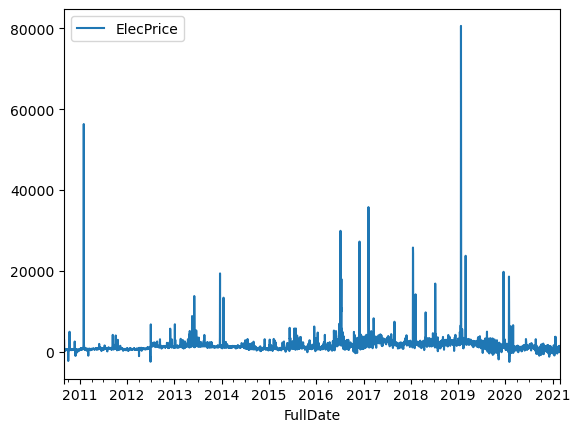

In [17]:
elec_daily_df.plot()

### Train

In [18]:
# Reset the index to make 'FullDate' a column for Prophet
train1.reset_index(inplace=True)

# Initialize the Prophet model
prophet_model1 = Prophet()

# Rename columns as required by Prophet
prophet_train = train1.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'})

# Fit the model on the training data
prophet_model1.fit(prophet_train)

10:30:06 - cmdstanpy - INFO - Chain [1] start processing
10:30:08 - cmdstanpy - INFO - Chain [1] done processing


### Test

In [19]:
# Reset the index to make 'FullDate' a column for test data
test1.reset_index(inplace=True)

# Rename columns as required by Prophet
prophet_test1 = test1.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'})

# Make predictions on the test data
prophet_pred1 = prophet_model1.predict(prophet_test1)

### Evaluate

In [20]:
# Evaluation
mae1 = mean_absolute_error(prophet_test1['y'], prophet_pred1['yhat'])
mse1 = mean_squared_error(prophet_test1['y'], prophet_pred1['yhat'])
rmse1 = np.sqrt(mse1)
mape1 = calculate_mape(prophet_test1['y'], prophet_pred1['yhat'])

print("MAE:", round(mae1, 2))
print("MSE:", round(mse1, 2))
print("RMSE:", round(rmse1, 2))
print("MAPE", mape1)

MAE: 1730.99
MSE: 10287809.45
RMSE: 3207.46
MAPE 544.09


#### Plot components

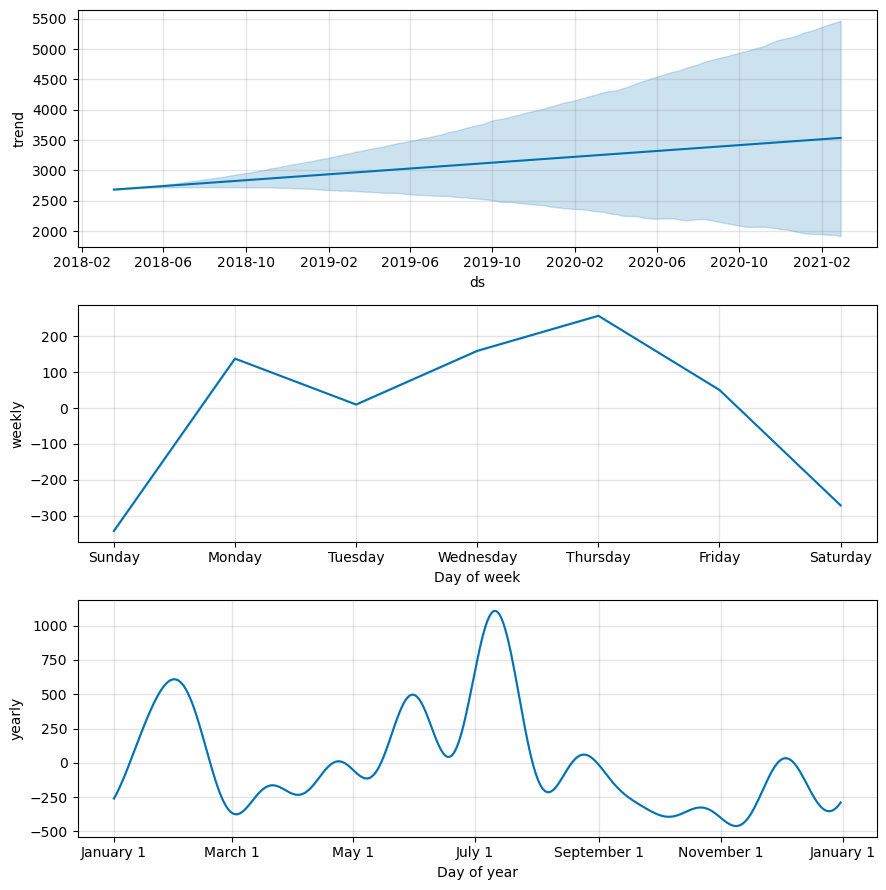

In [21]:
# Plot the components
fig = prophet_model1.plot_components(prophet_pred1)
plt.show()

## Task 2

In the last exercise, we used only the dependent variable (ElecPrice) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last x-2757 days of ElecPrice.

### Split

In [22]:
# Split ElecPrice to train and test set
train2 = daily_data.iloc[:2757]
test2 = daily_data.iloc[2757:]

# Print shape of train and test set
print("Shape of train set", train2.shape)
print("Shape of test set", test2.shape)

Shape of train set (2757, 4)
Shape of test set (1077, 4)


### Train

In [23]:
# Reset the index to make 'FullDate' a column for Prophet
train2.reset_index(inplace=True)

# Initialize the Prophet model with regressors
prophet_model2 = Prophet()

# Add the regressors (independent variables) to the model
prophet_model2.add_regressor('add1')
prophet_model2.add_regressor('add2')
prophet_model2.add_regressor('add3')

# Rename columns as required by Prophet
prophet_train = train2.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y',
                                      'SysLoad': 'add1', 'Tmax': 'add2', 'GasPrice': 'add3'})

# Fit the model on the training data with regressors
prophet_model2.fit(prophet_train)

10:30:15 - cmdstanpy - INFO - Chain [1] start processing
10:30:17 - cmdstanpy - INFO - Chain [1] done processing


### Test

In [24]:
# Reset the index to make 'FullDate' a column for test data
test2.reset_index(inplace=True)

# Create a DataFrame with the regressors for the test set
prophet_test2 = test2.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y',
                                    'SysLoad': 'add1', 'Tmax': 'add2', 'GasPrice': 'add3'})

# Make predictions on the test data with regressors
prophet_pred2 = prophet_model2.predict(prophet_test2)


### Evaluate

In [25]:
# Evaluation
mae2 = mean_absolute_error(prophet_test2['y'], prophet_pred2['yhat'])
mse2 = mean_squared_error(prophet_test2['y'], prophet_pred2['yhat'])
rmse2 = np.sqrt(mse2)
mape2 = calculate_mape(prophet_test2['y'], prophet_pred2['yhat'])

print("MAE:", round(mae2, 2))
print("MSE:", round(mse2, 2))
print("RMSE:", round(rmse2, 2))
print("MAPE", mape2)

MAE: 1005.35
MSE: 7363222.43
RMSE: 2713.53
MAPE 237.34


#### Plot components

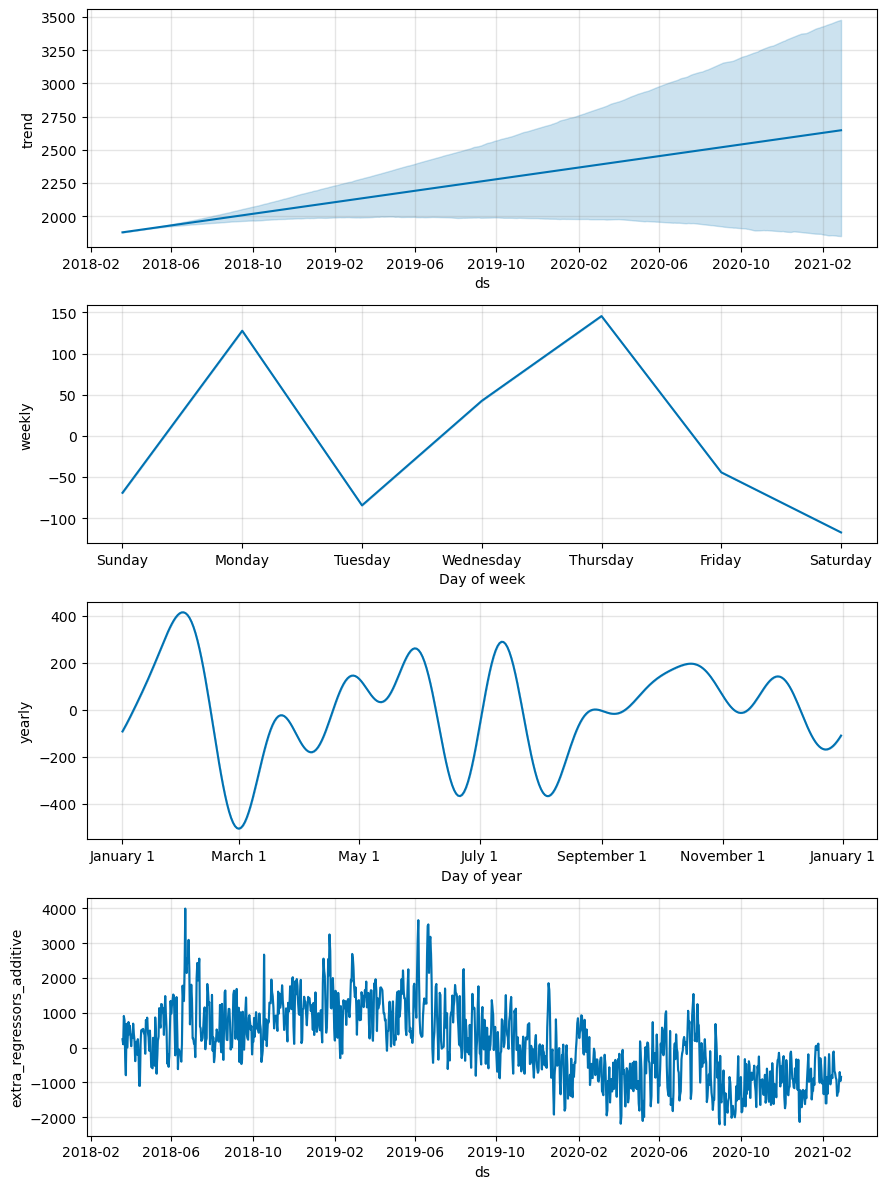

In [26]:
# Plot the components
fig = prophet_model2.plot_components(prophet_pred2)
plt.show()

## Task 3

Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),
What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?


### Split

In [27]:
# Split ElecPrice to train and test set
train3 = daily_data.drop('Tmax',axis =1).iloc[:2757]
test3 = daily_data.drop('Tmax', axis =1).iloc[2757:]

# Print shape of train and test set
print("Shape of train set", train3.shape)
print("Shape of test set", test3.shape)

Shape of train set (2757, 3)
Shape of test set (1077, 3)


### Train

In [28]:
# Reset the index to make 'FullDate' a column for Prophet
train3.reset_index(inplace=True)

# Initialize the Prophet model with regressors
prophet_model3 = Prophet()

# Add the regressors (independent variables) to the model
prophet_model3.add_regressor('add1')
prophet_model3.add_regressor('add2')

# Rename columns as required by Prophet
prophet_train = train3.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y',
                                      'SysLoad': 'add1', 'GasPrice': 'add2'})

# Fit the model on the training data with regressors
prophet_model3.fit(prophet_train)

10:30:27 - cmdstanpy - INFO - Chain [1] start processing
10:30:28 - cmdstanpy - INFO - Chain [1] done processing


### Test

In [29]:
# Reset the index to make 'FullDate' a column for test data
test3.reset_index(inplace=True)

# Create a DataFrame with the regressors for the test set
prophet_test3 = test3.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y',
                                    'SysLoad': 'add1', 'GasPrice': 'add2'})

# Make predictions on the test data with regressors
prophet_pred3 = prophet_model3.predict(prophet_test3)


### Evaluate

In [30]:
# Evaluation
mae3 = mean_absolute_error(prophet_test3['y'], prophet_pred3['yhat'])
mse3 = mean_squared_error(prophet_test3['y'], prophet_pred3['yhat'])
rmse3 = np.sqrt(mse3)
mape3 = calculate_mape(prophet_test3['y'], prophet_pred3['yhat'])

print("MAE:", round(mae3, 2))
print("MSE:", round(mse3, 2))
print("RMSE:", round(rmse3, 2))
print("MAPE", mape3)

MAE: 985.5
MSE: 7330035.85
RMSE: 2707.4
MAPE 231.58
